# Predict Beer Consumption - Regression

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt

import warnings

import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_log_error, confusion_matrix

### Einlesen und erste Analyse der Daten

In [2]:
train = pd.read_csv("./resources/Consumo_cerveja.csv")
train.head()

,Data,Temperatura Media (C),Temperatura Minima (C),Temperatura Maxima (C),Precipitacao (mm),Final de Semana,Consumo de cerveja (litros)
0,2015-01-01,"27,3","23,9","32,5",0,0,25.461
1,2015-01-02,"27,02","24,5","33,5",0,0,28.972
2,2015-01-03,"24,82","22,4","29,9",0,1,30.814
3,2015-01-04,"23,98","21,5","28,6","1,2",1,29.799
4,2015-01-05,"23,82",21,"28,3",0,0,28.900


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 7 columns):
Data                           365 non-null object
Temperatura Media (C)          365 non-null object
Temperatura Minima (C)         365 non-null object
Temperatura Maxima (C)         365 non-null object
Precipitacao (mm)              365 non-null object
Final de Semana                365 non-null int64
Consumo de cerveja (litros)    365 non-null float64
dtypes: float64(1), int64(1), object(5)
memory usage: 20.0+ KB


In [4]:
train.describe()

,Final de Semana,Consumo de cerveja (litros)
count,365.000000,365.000000
mean,0.284932,25.401367
std,0.452001,4.399143
min,0.000000,14.343000
25%,0.000000,22.008000
50%,0.000000,24.867000
75%,1.000000,28.631000
max,1.000000,37.937000


### Die Datumsspalte ist nicht sonderlich aussagekräftig. Es sollte für die Vorhersage im Wesentlichen egal sein, ob es in einer typischen Woche Dienstag oder Mittwoch ist. Allerdings können wir aus der Spalte trotzdem relvante Daten extrahieren. Zum Beispiel können wir eine neue Spalte, nämlich die Jahreszeit, aus der vorhandenen extrahieren. Intuitive sollte es nämlich einen Einfluss haben, ob es Winter (geringerer Konsum erwartet) oder Sommer (hoher Konsum erwartet) ist. 

In [5]:
def find_season(date):
    splitted_date = date.split('-')
    month = splitted_date[1]
    if int(month) is 12 or int(month) <= 2:
        return 'Summer'
    if int(month) <= 5:
        return 'Autumn'
    if int(month) <= 8:
        return 'Winter'
    return 'Spring'

In [7]:
find_season('2015-06-18')

'Winter'

In [8]:
train['Data'] = train['Data'].apply(lambda date : find_season(date))

In [9]:
train.head()

,Data,Temperatura Media (C),Temperatura Minima (C),Temperatura Maxima (C),Precipitacao (mm),Final de Semana,Consumo de cerveja (litros)
0,Summer,"27,3","23,9","32,5",0,0,25.461
1,Summer,"27,02","24,5","33,5",0,0,28.972
2,Summer,"24,82","22,4","29,9",0,1,30.814
3,Summer,"23,98","21,5","28,6","1,2",1,29.799
4,Summer,"23,82",21,"28,3",0,0,28.900


### Konvertierung der Temperaturspalten in numerisches Format

In [10]:
def map_to_number(df, column_name):
    df[column_name] = df[column_name].apply(lambda x : x.replace(',', '.'))
    df[column_name] = df[column_name].apply(lambda x: float(x))

In [11]:
map_to_number(train, 'Temperatura Media (C)')
map_to_number(train, 'Temperatura Minima (C)')
map_to_number(train, 'Temperatura Maxima (C)')
map_to_number(train, 'Precipitacao (mm)')

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 7 columns):
Data                           365 non-null object
Temperatura Media (C)          365 non-null float64
Temperatura Minima (C)         365 non-null float64
Temperatura Maxima (C)         365 non-null float64
Precipitacao (mm)              365 non-null float64
Final de Semana                365 non-null int64
Consumo de cerveja (litros)    365 non-null float64
dtypes: float64(5), int64(1), object(1)
memory usage: 20.0+ KB


### Wir trennen die Variablen in numerisch (kontinuierlich) und kategorisch (diskret) um später die SciKit-Learn API effizient verwenden zu können.

In [13]:
numerical_vars = ['Temperatura Media (C)', 'Temperatura Minima (C)', 'Temperatura Maxima (C)', 'Precipitacao (mm)']
categorical_vars = ['Data', 'Final de Semana']

### Mittels SciKit-Learn können wir sehr einfach die Verteilungen der verschiedenen numerischen Variablen einsehen. In den plots sieht man, dass die Temperaturen einer Normalverteilung folgen. Der Niederschlag hingegen, ist bei stark bei 0 gepeakt. Dies ist ein erster Hinweis darauf, dass diese Spalte für unser Problem nicht sonderlich hilfreich seien sollte. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000212A77A7240>,
      dtype=object)

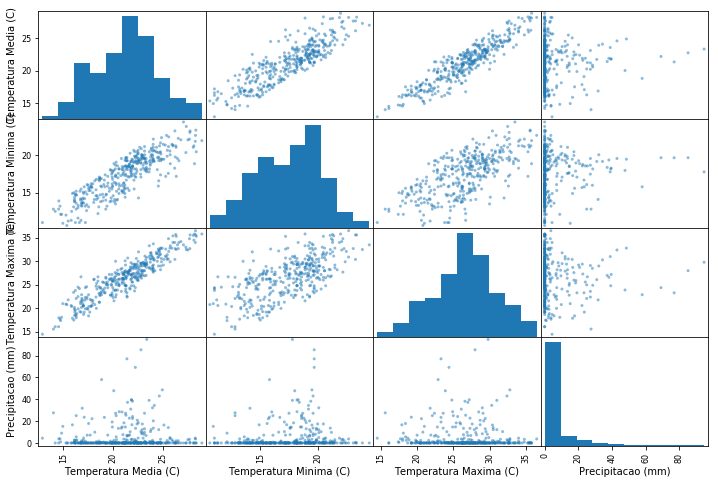

In [14]:
scatter_matrix(train[numerical_vars], figsize=(12,8))

In [15]:
correlation_matrix = train.corr()
correlation_matrix["Consumo de cerveja (litros)"].sort_values(ascending=False)

Consumo de cerveja (litros)    1.000000
Temperatura Maxima (C)         0.642672
Temperatura Media (C)          0.574615
Final de Semana                0.505981
Temperatura Minima (C)         0.392509
Precipitacao (mm)             -0.193784
Name: Consumo de cerveja (litros), dtype: float64

### Machine Learning Algorithmen basieren auf mathematischen Algorithmen. Daher müssen wir alle Spalten in ein numerisches Format transformieren. 

In [16]:
class DataFrameSelector(BaseEstimator, TransformerMixin):

     def __init__(self, attribute_names):
         self.attribute_names = attribute_names

     def fit(self, X, y=None):
         return self

     def transform(self, X):
         return X[self.attribute_names].values

In [17]:
num_pipeline = Pipeline([
    ('select_numeric', DataFrameSelector(numerical_vars)),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('select_categorical', DataFrameSelector(categorical_vars)),
    ('cat_encoder', OneHotEncoder()),
])

full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline),
])

### Als nächstes trennen wir die Daten in unabhängige und abhängige (vorherzusagende) Variable und splitten die Daten zufällig in einen Trainings- und in einen Validierungsanteil.

In [18]:
train_X = train.drop(columns=['Consumo de cerveja (litros)'])
labels_X = train['Consumo de cerveja (litros)']

In [19]:
X_train_prepared = full_pipeline.fit_transform(train_X)

In [20]:
X_train, X_val, y_train, y_val = \
    train_test_split(X_train_prepared, labels_X.values, test_size=0.1, random_state=42)

In [21]:
X_train

<328x10 sparse matrix of type '<class 'numpy.float64'>'
	with 1968 stored elements in Compressed Sparse Row format>

### Das Machine Learning Model, das als erstes trainiert werden soll, ist ein sogenannter Random Forest. Um sinnvolle Parameter zu finden wird außerdem die GridSearchCV Klasse von SciKit-Learn verwendet. 

In [22]:
param_grid = [
    {'n_estimators': [35, 40, 45, 50, 55, 60], 'max_depth': [2, 3, 5, 7], 'max_features': [3,5,7]}
]

In [31]:
forest = RandomForestRegressor()
grid_search = GridSearchCV(forest, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

grid_search.best_params_

C:\Users\trug\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'max_depth': 7, 'max_features': 3, 'n_estimators': 50}

In [33]:
scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
tree_rmse_scores = np.sqrt(-scores)
print('Scores:', tree_rmse_scores)
print('Mean:', tree_rmse_scores.mean())
print('Standard Deviation:', tree_rmse_scores.std())

Scores: [2.72875705 2.42214656 2.44101375 2.61939866 2.50310519]
Mean: 2.5428842418591566
Standard Deviation: 0.11570714409427259


In [34]:
best_forest = grid_search.best_estimator_

feature_importances = best_forest.feature_importances_
all_attributes = categorical_vars + numerical_vars
sorted(zip(feature_importances, all_attributes), reverse=True)

[(0.3680003418366537, 'Temperatura Media (C)'),
 (0.18276557847126582, 'Data'),
 (0.07956008864055655, 'Final de Semana'),
 (0.061156390812209, 'Temperatura Minima (C)'),
 (0.0195791853926704, 'Temperatura Maxima (C)'),
 (0.012203312981410816, 'Precipitacao (mm)')]

### Wir sehen, dass die Durchschnittstemperatur den größten Einfluss auf den Konsum hat. Auch die von uns extrahierte Jahreszeit hat eine gewisse Bedeutung. Die Tatsache, dass maximale und minimale Temperatur nur eine geringe Bedeutung haben, könnte an der fast linearen Korrelation dieser Größen mit der Durchschnittstemperturatur liegen. Somit sollte wenig neue Information in erst genannten enthalten sein. Schließlich erkennt man, dass die Niederschlag fast komplett zu vernachlässigen ist. Dies hatten wir bereits bei der Betrachtung der Verteilungen erwartet. 

In [36]:
best_forest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

### Zum Schluss evaluieren wir unser trainiertes Model auf dem Validierungsdatensatz.

In [37]:
class ModelEvaluator:

    def evaluate_model(self, best_forest, input, labels, limit):
        predictions = best_forest.predict(input)
        some_predictions = predictions[:limit]
        some_labels = list(labels)[:limit]

        differences = np.array(some_predictions) - np.array(some_labels)
        relative_errors = differences / np.array(some_labels)
        rmsle = np.sqrt(mean_squared_log_error(list(labels), predictions))
        
        plt.plot(some_labels, label='true labels', linewidth=2)
        plt.plot(some_predictions, label='predicted labels', linewidth=2)
        plt.show()

        return differences, relative_errors, rmsle

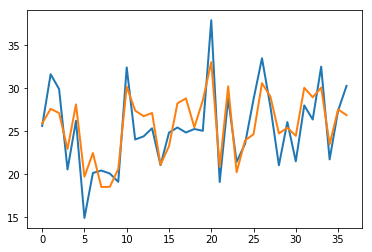

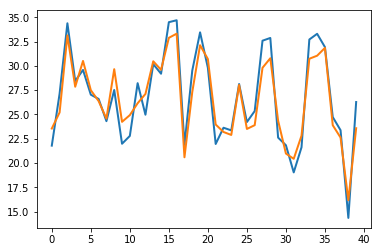

In [38]:
model_evaluator = ModelEvaluator()
differences_validation, relative_validation_errors, rmsle_validation = model_evaluator.evaluate_model(best_forest, X_val, y_val, 40)
differences_train, relative_train_errors, rmsle_train = model_evaluator.evaluate_model(best_forest, X_train, y_train, 40)

In [40]:
np.absolute(differences_train) < 4.4

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [41]:
np.absolute(differences_validation) < 4.4

array([ True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [42]:
relative_validation_errors

array([ 0.01122553, -0.12726033, -0.09334145,  0.1157155 ,  0.07258997,
        0.32080967,  0.11513459, -0.09365253, -0.07694727,  0.07739668,
       -0.06910606,  0.13990703,  0.09595805,  0.07035331,  0.00288538,
       -0.06362651,  0.11031069,  0.15970682,  0.00796129,  0.14128839,
       -0.12855386,  0.09216517,  0.04871575, -0.05604265,  0.01693672,
       -0.1417331 , -0.08639446,  0.04221717,  0.17592903, -0.02515887,
        0.13808829,  0.07320151,  0.09792373, -0.07470288,  0.08040842,
        0.00504344, -0.11225568])

In [43]:
rmsle_validation

0.09914273951205119

### Wie oben gesehen, scheint die mittlere Tagestemperatur das eindeutig wichtigste feature zu sein. Daher versuchen wir nun ein simples lineares Modell und stellen dies unser Forest gegenüber.

In [56]:
from sklearn.linear_model import LinearRegression

In [57]:
linear_regression = LinearRegression()

In [58]:
linear_regression.fit(train['Temperatura Media (C)'].values.reshape(-1, 1), train['Consumo de cerveja (litros)'].values)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

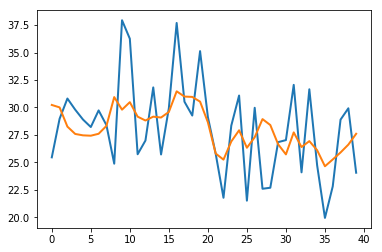

In [59]:
differences_train, relative_train_errors, rmsle_train = model_evaluator.evaluate_model(linear_regression, train['Temperatura Media (C)'].values.reshape(-1, 1), train['Consumo de cerveja (litros)'].values, 40)

In [62]:
np.absolute(differences_train) < 4.4

array([False,  True,  True,  True,  True,  True,  True,  True, False,
       False, False,  True,  True,  True,  True,  True, False,  True,
        True, False,  True,  True,  True,  True,  True, False,  True,
       False, False,  True,  True,  True,  True, False,  True, False,
        True,  True,  True,  True])